In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
df = pd.read_csv('Housing.csv')

In [28]:
df.describe()


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [29]:
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [30]:
df.tail()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


In [31]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [32]:
encoders = {}
for col in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    encoders[col] = encoder

In [33]:
X = df.drop(['price'], axis=1)
y = df['price']

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [36]:
rf = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

In [38]:
param_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}

In [39]:
grid_rf = GridSearchCV(rf, param_rf, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

In [40]:
param_gbr = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

In [41]:
grid_gbr = GridSearchCV(gbr, param_gbr, cv=3, scoring='neg_mean_squared_error')
grid_gbr.fit(X_train, y_train)
best_gbr = grid_gbr.best_estimator_

In [44]:
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    random_state=42
)

In [45]:
bagging_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)

In [46]:
adaboost_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

In [47]:
adaboost_model.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4),
                  learning_rate=0.1, n_estimators=100, random_state=42)

In [48]:
voting_model = VotingRegressor(
    estimators=[
        ('RandomForest', best_rf),
        ('GradientBoosting', best_gbr),
        ('Bagging', bagging_model),
        ('AdaBoost', adaboost_model)
    ]
)

In [49]:
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)

In [50]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [51]:
print("Voting Regressor with Bagging and Boosting:")
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 3))

Voting Regressor with Bagging and Boosting:
MSE: 1881952292369.91
RMSE: 1371842.66
R² Score: 0.628


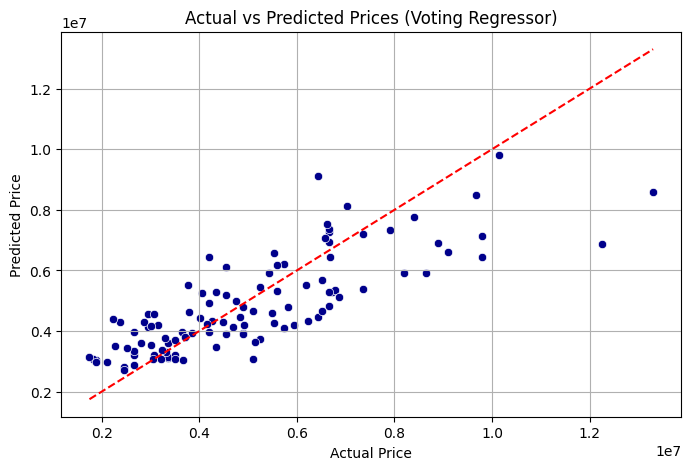

In [52]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, color='darkblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Prices (Voting Regressor)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

In [53]:
importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

C:\Users\brijm\AppData\Local\Temp\ipykernel_36264\1407532681.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')


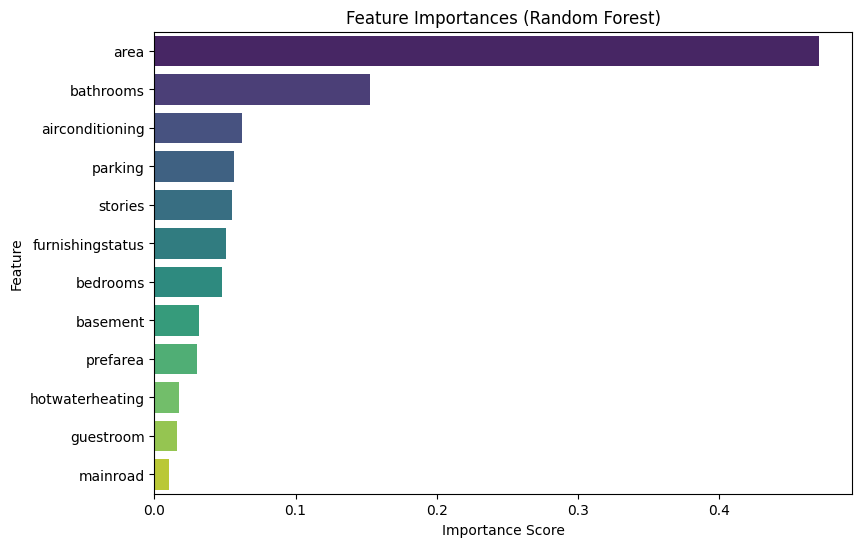

In [54]:
plt.figure(figsize=(9, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()